# Импорт библиотек

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist, fashion_mnist 
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image
import numpy as np  
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 

import os 
from google.colab import drive 
import time, random
import seaborn as sns
sns.set_style('darkgrid') 

# Подключение к Гугл Диску

In [ ]:
drive.mount('/content/drive/')  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Вспомогательные функции

## Функция создания автокодировщика

In [ ]:
def baseAutoencoder(shape=(112,80,1)): 
    img_input = Input((shape)) 

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = MaxPooling2D()(x) 

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 
    z = MaxPooling2D()(x) 
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) 
    x = BatchNormalization()(x) 
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
     
    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) 
    x = BatchNormalization()(x) 

    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error')

    return model

## Функция вывода изображений

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): 
  n = 5 
  plt.figure(figsize=(14, 7)) 
  for i in range(n): 
      index = np.random.randint(0, pred.shape[0]) 
 
      ax = plt.subplot(2, n, i + 1) 
      plt.imshow(xTrain[index].reshape(shape)) 
      plt.gray() 
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False) 
 
      ax = plt.subplot(2, n, i + 1 + n) 
      plt.imshow(pred[index].reshape(shape))   
      plt.gray() 
      ax.get_xaxis().set_visible(False) 
      ax.get_yaxis().set_visible(False) 
  plt.show()

## Функция получения средней квадратичной ошибки

In [ ]:
def getMSE(x1, x2): 
  x1 = x1.flatten() 
  x2 = x2.flatten() 
  delta = x1 - x2 
  return sum(delta ** 2) / len(delta) 

In [ ]:
x1 = np.array([1, 1, 1]) 
x2 = np.array([1, 1, 1]) 
print(getMSE(x1,x2))

0.0


## Функция создания шума

In [ ]:
def addNoise(x, noiseVal):
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape)
  
  return np.clip(x + noiseVal * noise, 0., 1.) 

## Функция для загрузки изображений

In [ ]:
def load_images(images_dir, img_height, img_width): 
  list_images = []
  for img in os.listdir(images_dir):
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) 

# Создание и обучение автокодировщика для работы с Fashion mnist

## Подготовка данных

In [ ]:
(xTrainMnistF, yTrainMnistF), (xTestMnistF, yTestMnistF) = fashion_mnist.load_data()
xTrainMnistF = xTrainMnistF.astype('float32')/255
xTrainMnistF = xTrainMnistF.reshape(xTrainMnistF.shape[0], 28, 28, 1)

xTestMnistF = xTestMnistF.astype('float32')/255
xTestMnistF = xTestMnistF.reshape(xTestMnistF.shape[0], 28, 28, 1)

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print(xTrainMnistF.shape)
print(xTestMnistF.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


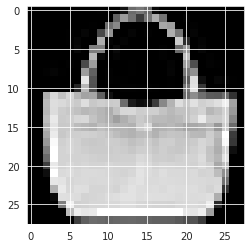

In [ ]:
n = 100
plt.imshow(xTrainMnistF[n].reshape((28,28)), cmap='gray')
plt.show()

In [ ]:
modelAutoFashionMnist = baseAutoencoder((28,28,1))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
modelAutoFashionMnist.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496 

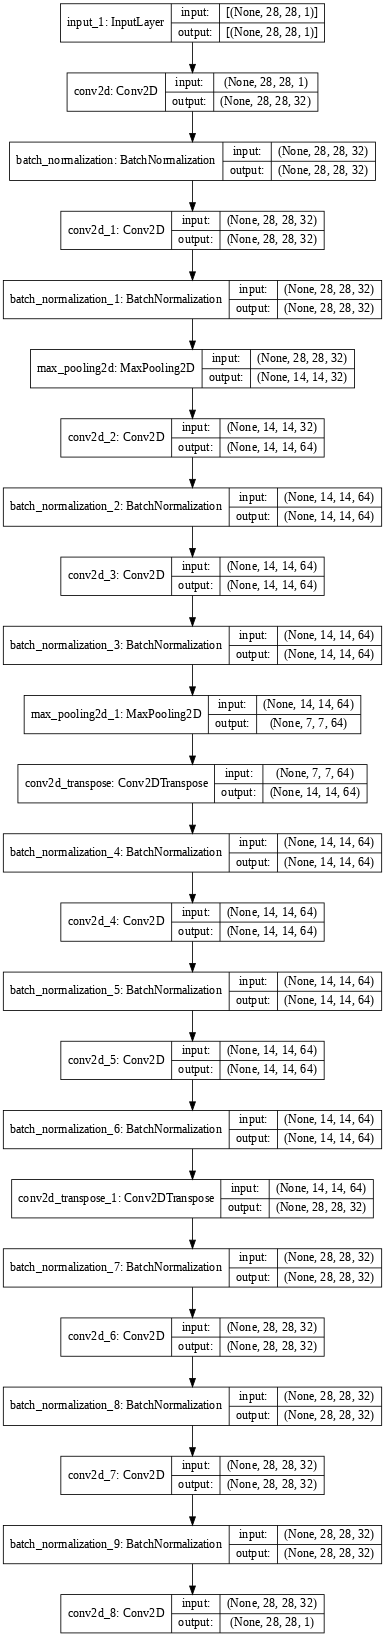

In [ ]:
utils.plot_model(modelAutoFashionMnist, dpi=60, show_shapes=True)

In [ ]:
history = modelAutoFashionMnist.fit(xTrainMnistF, xTrainMnistF, epochs=5, batch_size=256, validation_data = (xTestMnistF, xTestMnistF))

Epoch 1/5
235/235 [==============================] - 53s 92ms/step - loss: 0.0410 - val_loss: 0.1080
Epoch 2/5
235/235 [==============================] - 21s 88ms/step - loss: 0.0154 - val_loss: 0.0234
Epoch 3/5
235/235 [==============================] - 21s 88ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 4/5
235/235 [==============================] - 21s 88ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 5/5
235/235 [==============================] - 21s 88ms/step - loss: 0.0080 - val_loss: 0.0075


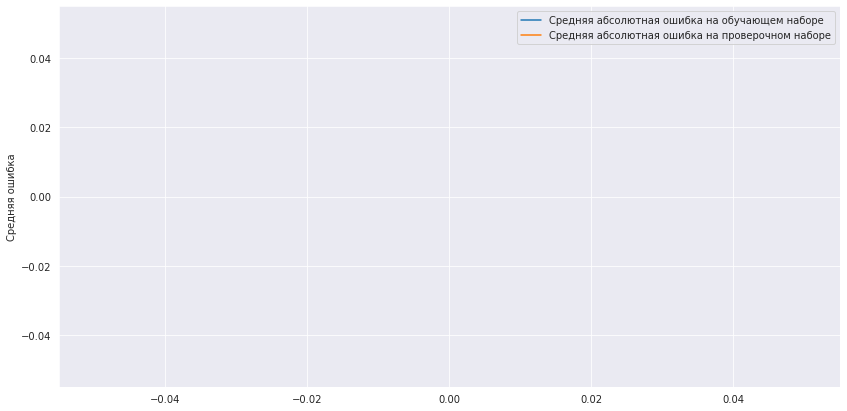

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predMnistF = modelAutoFashionMnist.predict(xTestMnistF)
predMnistF = predMnistF * 255
predMnistF = predMnistF.astype('uint8')

In [ ]:
errF = [getMSE(xTrainMnistF[i], predMnistF[i] / 255) for i in range(len(predMnistF))]
print("Средняя ошибка на одежде:", round(sum(errF) / len(errF), 4))
print()
print("Минимальная ошибка на одежде:", round(min(errF),4))

Средняя ошибка на одежде: 0.177

Минимальная ошибка на одежде: 0.012


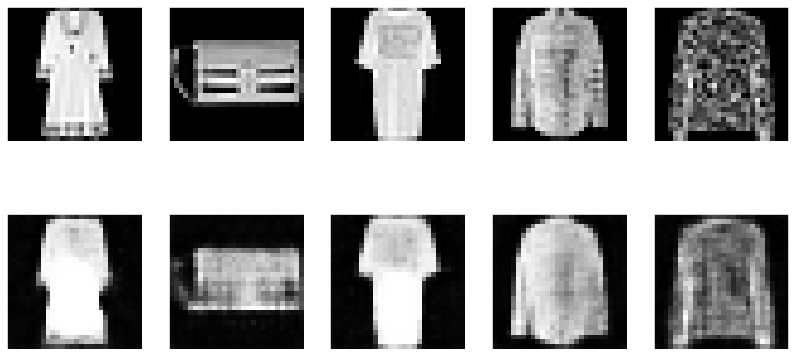

In [ ]:
plotImages(xTestMnistF, predMnistF, shape=(28,28))